/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Successfully imported libraries. Using MedMNIST version: 3.0.2
INFO: The data_flag is set to: 'breastmnist'
INFO: Datasets and Dataloaders are ready.
INFO: ResNet-18 model is defined and moved to device: cuda:0
INFO: Starting training for 100 epochs...


Epoch 1/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 14.13it/s]


Epoch 1/100 - Validation AUC: 0.353, Accuracy: 0.731


Epoch 2/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.10it/s]


Epoch 2/100 - Validation AUC: 0.519, Accuracy: 0.731


Epoch 3/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


Epoch 3/100 - Validation AUC: 0.566, Accuracy: 0.731


Epoch 4/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.23it/s]


Epoch 4/100 - Validation AUC: 0.707, Accuracy: 0.731


Epoch 5/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s]


Epoch 5/100 - Validation AUC: 0.764, Accuracy: 0.769


Epoch 6/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.85it/s]


Epoch 6/100 - Validation AUC: 0.799, Accuracy: 0.782


Epoch 7/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.47it/s]


Epoch 7/100 - Validation AUC: 0.821, Accuracy: 0.821


Epoch 8/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.75it/s]


Epoch 8/100 - Validation AUC: 0.826, Accuracy: 0.808


Epoch 9/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.70it/s]


Epoch 9/100 - Validation AUC: 0.819, Accuracy: 0.782


Epoch 10/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.54it/s]


Epoch 10/100 - Validation AUC: 0.836, Accuracy: 0.795


Epoch 11/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.13it/s]


Epoch 11/100 - Validation AUC: 0.856, Accuracy: 0.795


Epoch 12/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.19it/s]


Epoch 12/100 - Validation AUC: 0.876, Accuracy: 0.846


Epoch 13/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 15.46it/s]


Epoch 13/100 - Validation AUC: 0.889, Accuracy: 0.846


Epoch 14/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 15.96it/s]


Epoch 14/100 - Validation AUC: 0.893, Accuracy: 0.833


Epoch 15/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.73it/s]


Epoch 15/100 - Validation AUC: 0.884, Accuracy: 0.808


Epoch 16/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.56it/s]


Epoch 16/100 - Validation AUC: 0.884, Accuracy: 0.808


Epoch 17/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.02it/s]


Epoch 17/100 - Validation AUC: 0.890, Accuracy: 0.808


Epoch 18/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.13it/s]


Epoch 18/100 - Validation AUC: 0.891, Accuracy: 0.821


Epoch 19/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.72it/s]


Epoch 19/100 - Validation AUC: 0.886, Accuracy: 0.795


Epoch 20/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.56it/s]


Epoch 20/100 - Validation AUC: 0.888, Accuracy: 0.795


Epoch 21/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.01it/s]


Epoch 21/100 - Validation AUC: 0.886, Accuracy: 0.821


Epoch 22/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


Epoch 22/100 - Validation AUC: 0.889, Accuracy: 0.821


Epoch 23/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


Epoch 23/100 - Validation AUC: 0.890, Accuracy: 0.808


Epoch 24/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


Epoch 24/100 - Validation AUC: 0.894, Accuracy: 0.808


Epoch 25/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.01it/s]


Epoch 25/100 - Validation AUC: 0.895, Accuracy: 0.808


Epoch 26/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.71it/s]


Epoch 26/100 - Validation AUC: 0.892, Accuracy: 0.821


Epoch 27/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.61it/s]


Epoch 27/100 - Validation AUC: 0.896, Accuracy: 0.821


Epoch 28/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Epoch 28/100 - Validation AUC: 0.899, Accuracy: 0.808


Epoch 29/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Epoch 29/100 - Validation AUC: 0.898, Accuracy: 0.808


Epoch 30/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.54it/s]


Epoch 30/100 - Validation AUC: 0.901, Accuracy: 0.808


Epoch 31/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.76it/s]


Epoch 31/100 - Validation AUC: 0.900, Accuracy: 0.808


Epoch 32/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.74it/s]


Epoch 32/100 - Validation AUC: 0.901, Accuracy: 0.808


Epoch 33/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.00it/s]


Epoch 33/100 - Validation AUC: 0.899, Accuracy: 0.808


Epoch 34/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.05it/s]


Epoch 34/100 - Validation AUC: 0.899, Accuracy: 0.833


Epoch 35/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.98it/s]


Epoch 35/100 - Validation AUC: 0.898, Accuracy: 0.833


Epoch 36/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Epoch 36/100 - Validation AUC: 0.894, Accuracy: 0.808


Epoch 37/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Epoch 37/100 - Validation AUC: 0.894, Accuracy: 0.795


Epoch 38/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.88it/s]


Epoch 38/100 - Validation AUC: 0.893, Accuracy: 0.795


Epoch 39/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Epoch 39/100 - Validation AUC: 0.895, Accuracy: 0.795


Epoch 40/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


Epoch 40/100 - Validation AUC: 0.892, Accuracy: 0.795


Epoch 41/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.09it/s]


Epoch 41/100 - Validation AUC: 0.894, Accuracy: 0.795


Epoch 42/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.18it/s]


Epoch 42/100 - Validation AUC: 0.894, Accuracy: 0.808


Epoch 43/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.69it/s]


Epoch 43/100 - Validation AUC: 0.889, Accuracy: 0.795


Epoch 44/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


Epoch 44/100 - Validation AUC: 0.892, Accuracy: 0.795


Epoch 45/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 19.06it/s]


Epoch 45/100 - Validation AUC: 0.896, Accuracy: 0.795


Epoch 46/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.18it/s]


Epoch 46/100 - Validation AUC: 0.896, Accuracy: 0.795


Epoch 47/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.66it/s]


Epoch 47/100 - Validation AUC: 0.898, Accuracy: 0.808


Epoch 48/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.21it/s]


Epoch 48/100 - Validation AUC: 0.896, Accuracy: 0.808


Epoch 49/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


Epoch 49/100 - Validation AUC: 0.899, Accuracy: 0.821


Epoch 50/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.96it/s]


Epoch 50/100 - Validation AUC: 0.901, Accuracy: 0.808


Epoch 51/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.06it/s]


Epoch 51/100 - Validation AUC: 0.903, Accuracy: 0.821


Epoch 52/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.71it/s]


Epoch 52/100 - Validation AUC: 0.903, Accuracy: 0.821


Epoch 53/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 15.68it/s]


Epoch 53/100 - Validation AUC: 0.902, Accuracy: 0.821


Epoch 54/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 14.46it/s]


Epoch 54/100 - Validation AUC: 0.901, Accuracy: 0.821


Epoch 55/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.53it/s]


Epoch 55/100 - Validation AUC: 0.901, Accuracy: 0.808


Epoch 56/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.83it/s]


Epoch 56/100 - Validation AUC: 0.901, Accuracy: 0.821


Epoch 57/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Epoch 57/100 - Validation AUC: 0.900, Accuracy: 0.821


Epoch 58/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Epoch 58/100 - Validation AUC: 0.901, Accuracy: 0.821


Epoch 59/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.82it/s]


Epoch 59/100 - Validation AUC: 0.897, Accuracy: 0.808


Epoch 60/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.64it/s]


Epoch 60/100 - Validation AUC: 0.899, Accuracy: 0.808


Epoch 61/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.34it/s]


Epoch 61/100 - Validation AUC: 0.901, Accuracy: 0.808


Epoch 62/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.67it/s]


Epoch 62/100 - Validation AUC: 0.898, Accuracy: 0.808


Epoch 63/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.75it/s]


Epoch 63/100 - Validation AUC: 0.896, Accuracy: 0.808


Epoch 64/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.86it/s]


Epoch 64/100 - Validation AUC: 0.896, Accuracy: 0.808


Epoch 65/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.49it/s]


Epoch 65/100 - Validation AUC: 0.895, Accuracy: 0.808


Epoch 66/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.48it/s]


Epoch 66/100 - Validation AUC: 0.897, Accuracy: 0.821


Epoch 67/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.84it/s]


Epoch 67/100 - Validation AUC: 0.902, Accuracy: 0.821


Epoch 68/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.09it/s]


Epoch 68/100 - Validation AUC: 0.906, Accuracy: 0.821


Epoch 69/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.53it/s]


Epoch 69/100 - Validation AUC: 0.907, Accuracy: 0.833


Epoch 70/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.40it/s]


Epoch 70/100 - Validation AUC: 0.907, Accuracy: 0.833


Epoch 71/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.22it/s]


Epoch 71/100 - Validation AUC: 0.905, Accuracy: 0.821


Epoch 72/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.15it/s]


Epoch 72/100 - Validation AUC: 0.907, Accuracy: 0.833


Epoch 73/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.70it/s]


Epoch 73/100 - Validation AUC: 0.901, Accuracy: 0.821


Epoch 74/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.27it/s]


Epoch 74/100 - Validation AUC: 0.901, Accuracy: 0.821


Epoch 75/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.35it/s]


Epoch 75/100 - Validation AUC: 0.901, Accuracy: 0.833


Epoch 76/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.85it/s]


Epoch 76/100 - Validation AUC: 0.899, Accuracy: 0.808


Epoch 77/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.33it/s]


Epoch 77/100 - Validation AUC: 0.895, Accuracy: 0.808


Epoch 78/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.66it/s]


Epoch 78/100 - Validation AUC: 0.890, Accuracy: 0.808


Epoch 79/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.39it/s]


Epoch 79/100 - Validation AUC: 0.891, Accuracy: 0.808


Epoch 80/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.46it/s]


Epoch 80/100 - Validation AUC: 0.895, Accuracy: 0.808


Epoch 81/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.79it/s]


Epoch 81/100 - Validation AUC: 0.894, Accuracy: 0.795


Epoch 82/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.78it/s]


Epoch 82/100 - Validation AUC: 0.896, Accuracy: 0.821


Epoch 83/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.53it/s]


Epoch 83/100 - Validation AUC: 0.891, Accuracy: 0.821


Epoch 84/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.60it/s]


Epoch 84/100 - Validation AUC: 0.895, Accuracy: 0.821


Epoch 85/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.08it/s]


Epoch 85/100 - Validation AUC: 0.895, Accuracy: 0.821


Epoch 86/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.52it/s]


Epoch 86/100 - Validation AUC: 0.905, Accuracy: 0.808


Epoch 87/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.28it/s]


Epoch 87/100 - Validation AUC: 0.904, Accuracy: 0.808


Epoch 88/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.48it/s]


Epoch 88/100 - Validation AUC: 0.906, Accuracy: 0.808


Epoch 89/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.62it/s]


Epoch 89/100 - Validation AUC: 0.907, Accuracy: 0.808


Epoch 90/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.58it/s]


Epoch 90/100 - Validation AUC: 0.911, Accuracy: 0.821


Epoch 91/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 16.69it/s]


Epoch 91/100 - Validation AUC: 0.908, Accuracy: 0.821


Epoch 92/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 15.32it/s]


Epoch 92/100 - Validation AUC: 0.911, Accuracy: 0.821


Epoch 93/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 10.94it/s]


Epoch 93/100 - Validation AUC: 0.909, Accuracy: 0.833


Epoch 94/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 12.33it/s]


Epoch 94/100 - Validation AUC: 0.911, Accuracy: 0.833


Epoch 95/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 17.28it/s]


Epoch 95/100 - Validation AUC: 0.908, Accuracy: 0.846


Epoch 96/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 11.27it/s]


Epoch 96/100 - Validation AUC: 0.905, Accuracy: 0.833


Epoch 97/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.35it/s]


Epoch 97/100 - Validation AUC: 0.903, Accuracy: 0.833


Epoch 98/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 12.99it/s]


Epoch 98/100 - Validation AUC: 0.903, Accuracy: 0.833


Epoch 99/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 15.29it/s]


Epoch 99/100 - Validation AUC: 0.903, Accuracy: 0.833


Epoch 100/100 [Train]: 100%|██████████| 5/5 [00:00<00:00, 18.57it/s]


Epoch 100/100 - Validation AUC: 0.903, Accuracy: 0.833

INFO: Training complete!
INFO: Evaluating model on the final test set...


[Test]: 100%|██████████| 2/2 [00:00<00:00, 54.44it/s]


------------------------------
Final Test Results for ResNet-18:
Test AUC: 0.828
Test Accuracy: 0.814
------------------------------


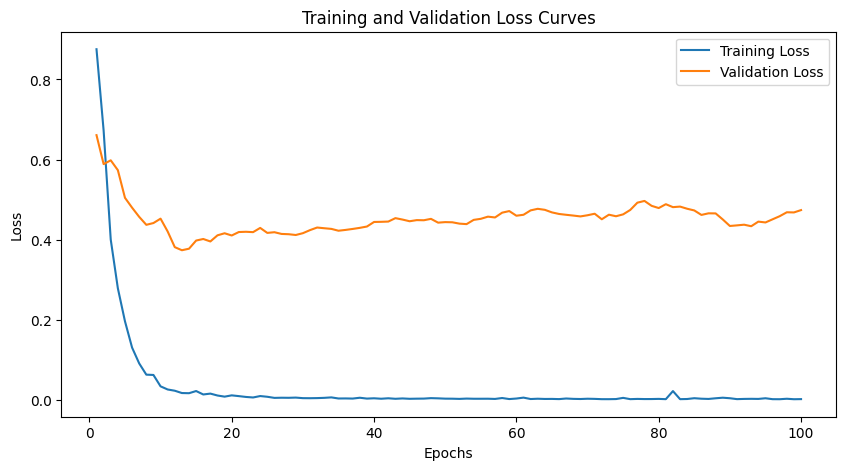

In [ ]:
# --- 1. Install and Import ---
# We run the installation quietly with `-q`
!pip install -q medmnist

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet18
import medmnist
from medmnist import INFO, Evaluator
from tqdm import tqdm
import matplotlib.pyplot as plt


print(f"Successfully imported libraries. Using MedMNIST version: {medmnist.__version__}")

# in the old style, I would use "print("Successfully imported libraries. Using MedMNIST version: %s" % (medmnist.__version__))"

# --- 2. Setup Dataset and Dataloaders ---

data_flag = 'breastmnist'
print(f"INFO: The data_flag is set to: '{data_flag}'") # Debug print

BATCH_SIZE = 128
download = True

# Get dataset information from the medmnist library
info = INFO[data_flag]
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Define transformations to apply to the images
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the datasets using the predefined splits and apply the transformations
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Create DataLoaders to handle batching and shuffling
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("INFO: Datasets and Dataloaders are ready.")

# --- 3. Define and Prepare the Model ---
# Use ResNet-18 and train from scratch (pretrained=False)
model = resnet18(pretrained=False)

# Adjust the model for our specific dataset (1-channel grayscale images)
model.conv1 = nn.Conv2d(n_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Adjust the final layer for our number of classes (2 for BreastMNIST)
model.fc = nn.Linear(model.fc.in_features, n_classes)

# Move the model to the GPU if one is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"INFO: ResNet-18 model is defined and moved to device: {device}")

# --- 4. Define Loss, Optimizer, and Training Parameters ---
NUM_EPOCHS = 100 # Set to a low number for a quick test. Increase to 100 for full replication.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

print(f"INFO: Starting training for {NUM_EPOCHS} epochs...")

# Create lists to store loss history
train_loss_history = []
val_loss_history = []

# --- 5. Training and Validation Loop ---
for epoch in range(NUM_EPOCHS):
    # Training phase
    model.train()

    running_train_loss = 0.0

    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{NUM_EPOCHS} [Train]"):
        inputs, targets = inputs.to(device), targets.to(device).squeeze().long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    epoch_train_loss = running_train_loss / len(train_loader)
    train_loss_history.append(epoch_train_loss)

    # Validation phase
    model.eval()
    y_true_val, y_score_val = [], []

    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.to(device)
            # Move targets to the same device for loss calculation
            targets = targets.to(device).squeeze().long()
            outputs = model(inputs)

            # Calculate the validation loss for the batch
            val_loss = criterion(outputs, targets)
            # Add the batch loss to the running total
            running_val_loss += val_loss.item()


            y_true_val.extend(targets.squeeze().tolist())
            y_score_val.extend(outputs.softmax(dim=-1).cpu().numpy())

    # Calculate average validation loss and append to history
    epoch_val_loss = running_val_loss / len(val_loader)
    val_loss_history.append(epoch_val_loss)


    # convert the list of arrays into a single NumPy array
    y_score_val = np.vstack(y_score_val)

    # Calculate validation metrics
    val_evaluator = Evaluator(data_flag, 'val')
    metrics = val_evaluator.evaluate(y_score_val)
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS} - Validation AUC: {metrics[0]:.3f}, Accuracy: {metrics[1]:.3f}")

print("\nINFO: Training complete!")

# --- 6. Final Evaluation on Test Set ---
print("INFO: Evaluating model on the final test set...")
model.eval()
y_true_test, y_score_test = [], []
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc="[Test]"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_true_test.extend(targets.squeeze().tolist())
        y_score_test.extend(outputs.softmax(dim=-1).cpu().numpy())

y_score_test = np.vstack(y_score_test)

# Calculate final test metrics
test_evaluator = Evaluator(data_flag, 'test')
test_auc, test_acc = test_evaluator.evaluate(y_score_test)

print("-" * 30)
print(f"Final Test Results for ResNet-18:")
print(f"Test AUC: {test_auc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")
print("-" * 30)

# Create a range of epochs for the x-axis
epochs_range = range(1, NUM_EPOCHS + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss_history, label='Training Loss')
plt.plot(epochs_range, val_loss_history, label='Validation Loss')

# Add labels and a title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend() # Show the legend

# Display the plot
plt.show()


INFO: {'pathmnist': {'python_class': 'PathMNIST', 'description': 'The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K into training and validation set with a ratio of 9:1. The CRC-VAL-HE-7K is treated as the test set.', 'url': 'https://zenodo.org/records/10519652/files/pathmnist.npz?download=1', 'MD5': 'a8b06965200029087d5bd730944a56c1', 'url_64': 'https://zenodo.org/records/10519652/files/pathmnist_64.npz?download=1', 'MD5_64': '55aa9c1e0525abe5a6b9d8343a507616', 'url_128': 'https://zenodo.org/records/10519652/files/pathmnist_128.npz?down

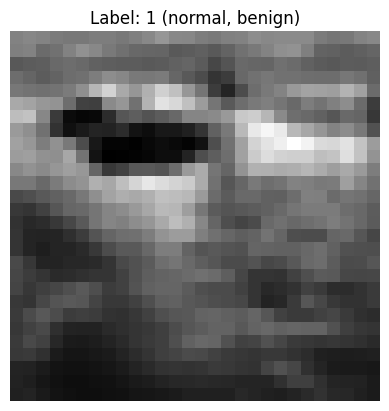

In [ ]:
# !pip install -q medmnist
# Import necessary libraries
# import numpy as np

# import medmnist
# from medmnist import INFO

import matplotlib.pyplot as plt

# Download and load the dataset
data_flag = 'breastmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

print(f"INFO: {INFO}")

print(f"Data Class: {DataClass}")
print(f"Info: {info}")

train_dataset = DataClass(split='train', download=True)

# Get the first image (as a PIL Image) and its label
pil_image, label = train_dataset[1]

# --- THE FIX ---
# Convert the PIL Image to a NumPy array
image = np.array(pil_image)

# --- Inspect the data (This section will now work correctly) ---
print(f"Image Data Type: {type(image)}")
print(f"Image Shape: {image.shape}")
print(f"Label Data Type: {type(label)}")
print(f"Label Value: {label}")

# --- Visualize the data ---
# Get the metadata to translate the label
label_name = info['label'][str(label[0])]

# Plot the image using matplotlib
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label[0]} ({label_name})")
plt.axis('off') # Hide the grid and axes
plt.show()